## Import libraries

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/cleaned_chicken_market_study_data.csv', sep=',')
df.head()

,Country Name,Country Code,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg),Poultry Consumption (kg),Import Dependency Ratio,Self-Sufficiency Ratio,Poultry Consumption Growth Potential
0,Afghanistan,AFG,40578842.0,85.3,1.435704,2.576854,10800465.0,-2.544956,-1.271806,1.9,-7.576669,357.261153,2.850314e+07,6902310.0,56040.0,3.578203e+07,19.525955,80.632576,9.220507e+07
1,Angola,AGO,35635029.0,48.5,3.143026,4.059358,24260684.0,-0.630109,-0.606699,2.1,-0.143628,2929.694455,5.717738e+07,308122710.0,10870.0,3.743962e+08,84.350343,15.652633,1.519808e+09
2,United Arab Emirates,ARE,10074977.0,100.0,5.088342,5.367449,8819937.0,0.744183,1.034781,4.0,2.176083,49899.065298,4.700000e+07,615447940.0,94007430.0,5.131117e+08,108.269543,8.268235,2.754101e+09
3,Argentina,ARG,45407904.0,100.0,0.210809,0.338668,41932837.0,-0.098594,-0.697566,2.8,5.048195,13935.681111,2.319469e+09,10218320.0,179621830.0,2.193142e+09,0.475256,107.878993,7.427477e+08
4,Armenia,ARM,2969200.0,100.0,0.232656,0.456271,1887610.0,-0.740756,-0.019079,2.5,12.338334,6571.974455,1.410000e+07,37595230.0,192800.0,5.287238e+07,72.997002,27.377349,2.412414e+07


## PCA: Dimensionality Reduction for Market Indicators
We will standardize selected numeric indicators, run PCA to reduce dimensionality, examine explained variance, visualize the 2D projection (PC1 vs PC2), and inspect feature loadings to interpret principal components.

### Features selection and scaling

In [4]:
# Select numeric features for PCA
numeric_cols = [
    # 'Total Population',
       'Access to Electricity (%)', 
    #    'Population Growth Rate',
      #  'Urban Population Growth Rate', 
       'Urban Population',
       'Political Stability Index', 'Regulatory Quality Index',
       'Logistics Performance Index',
        # 'GDP per Capita Growth (%)',
       'GDP per Capita (current US$)', 'Chicken Meat Production (kg)',
    #    'Import Quantity (kg)', 'Export Quantity (kg)',
       'Poultry Consumption (kg)', 'Import Dependency Ratio',
       'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential']

# Keep only columns that actually exist
numeric_cols = [c for c in numeric_cols if c in df.columns]
print('Using features for PCA:', numeric_cols)

# Filter data and drop rows with missing values in these columns
X = df[numeric_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

# Keep aligned country identifiers for later plots
id_cols = [c for c in ['Country or Area', 'Country Code'] if c in df.columns]
ids = df.loc[X.index, id_cols].copy() if id_cols else None

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Shape after cleaning:', X.shape)

Using features for PCA: ['Access to Electricity (%)', 'Urban Population', 'Political Stability Index', 'Regulatory Quality Index', 'Logistics Performance Index', 'GDP per Capita (current US$)', 'Chicken Meat Production (kg)', 'Poultry Consumption (kg)', 'Import Dependency Ratio', 'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential']
Shape after cleaning: (104, 11)


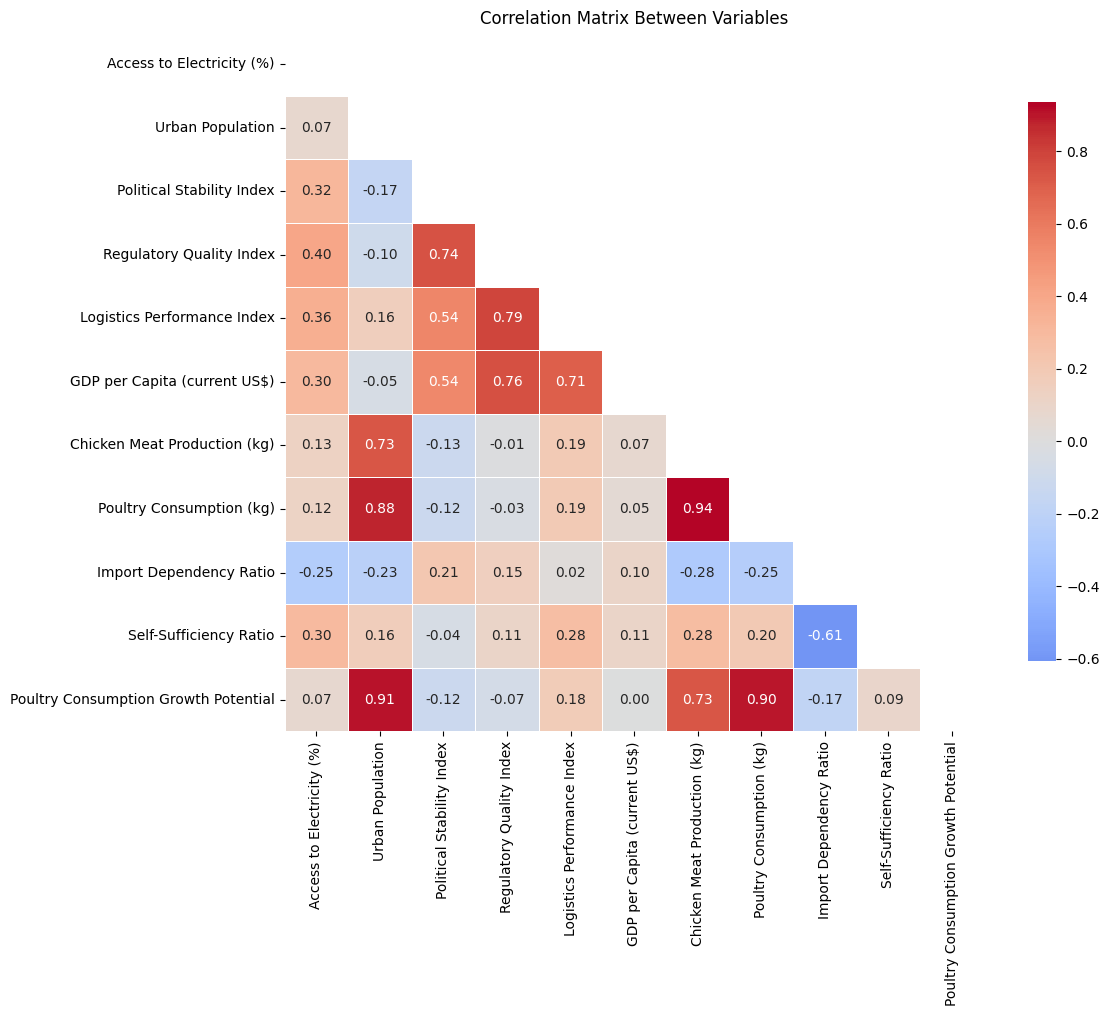

Urban Population ↔ Chicken Meat Production (kg): 0.73
Urban Population ↔ Poultry Consumption (kg): 0.88
Urban Population ↔ Poultry Consumption Growth Potential: 0.91
Political Stability Index ↔ Regulatory Quality Index: 0.74
Regulatory Quality Index ↔ Logistics Performance Index: 0.79
Regulatory Quality Index ↔ GDP per Capita (current US$): 0.76
Logistics Performance Index ↔ GDP per Capita (current US$): 0.71
Chicken Meat Production (kg) ↔ Poultry Consumption (kg): 0.94
Chicken Meat Production (kg) ↔ Poultry Consumption Growth Potential: 0.73
Poultry Consumption (kg) ↔ Poultry Consumption Growth Potential: 0.90


In [5]:
# Correlation matrix
correlation_matrix = X.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Between Variables')
plt.tight_layout()
plt.show()

# High correlations
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            print(f"{correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.2f}")

### Scree Plot

Explained variance ratio per component:
[0.3482 0.2993 0.1441 0.0636 0.0392 0.0331 0.0315 0.0201 0.0116 0.0077
 0.0016]
Cumulative explained variance:
[0.3482 0.6475 0.7916 0.8552 0.8944 0.9275 0.959  0.9791 0.9907 0.9984
 1.    ]


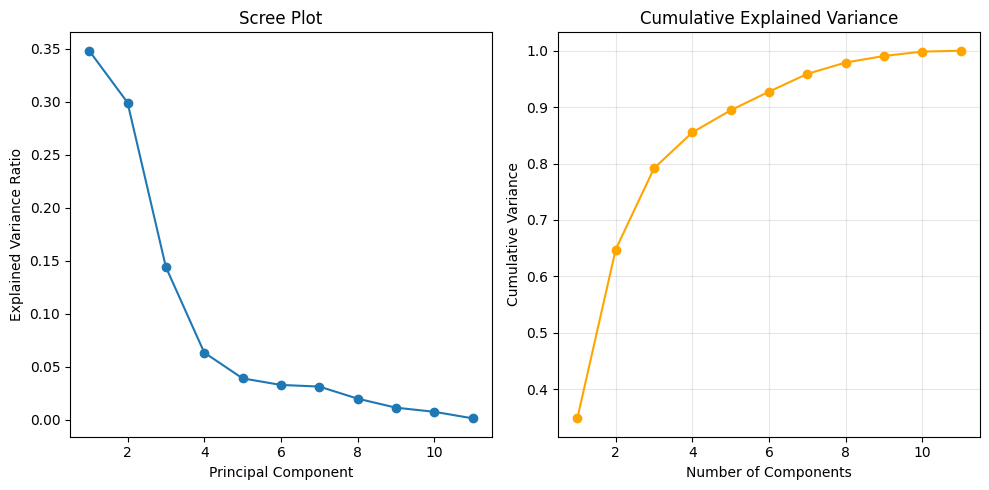

In [6]:
# Fit PCA on standardized data
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
print('Explained variance ratio per component:')
print(np.round(explained_var, 4))
print('Cumulative explained variance:')
print(np.round(np.cumsum(explained_var), 4))

# Scree plot and cumulative variance
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1,2,2)
plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var), marker='o', color='orange')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

visually we can see that first 4 components explain most of the variance, however we will try to examine statistically significant components using permutation test below.

Kaiser criterion (eigenvalue > 1): 3 components → 79.2% variance

80% variance threshold: 4 components
85% variance threshold: 4 components
90% variance threshold: 6 components


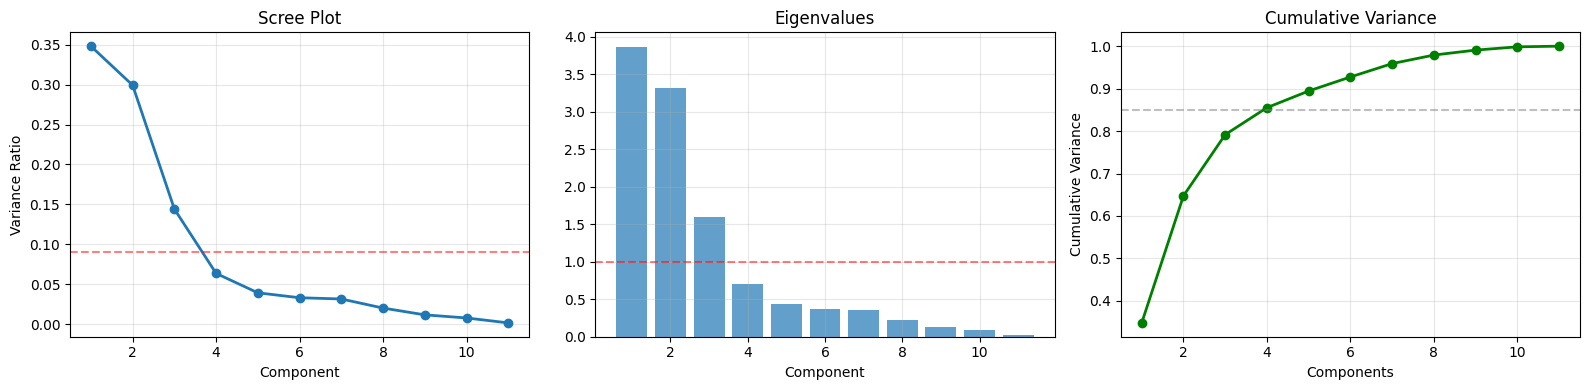


Decision: Use 3 components for clustering (79.2% variance)
Visualize with 2 components (PC1-PC2) for interpretability


In [7]:
eigenvalues = pca.explained_variance_
cumsum_var = np.cumsum(explained_var)

# Kaiser criterion
kaiser_n = (eigenvalues > 1).sum()
print(f"Kaiser criterion (eigenvalue > 1): {kaiser_n} components → {cumsum_var[kaiser_n-1]:.1%} variance\n")

# Variance thresholds
for threshold in [0.80, 0.85, 0.90]:
    n_comp = np.argmax(cumsum_var >= threshold) + 1
    print(f"{threshold:.0%} variance threshold: {n_comp} components")

# Broken stick model
def broken_stick(n):
    return np.array([sum(1/np.arange(i, n+1)) for i in range(1, n+1)]) / n

bs = broken_stick(len(eigenvalues))
broken_stick_n = (explained_var > bs).sum()

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Scree with Kaiser
axes[0].plot(range(1, len(explained_var)+1), explained_var, 'o-', linewidth=2)
axes[0].axhline(y=1/len(explained_var), color='r', linestyle='--', alpha=0.5)
axes[0].set_title('Scree Plot')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Variance Ratio')
axes[0].grid(alpha=0.3)

# Eigenvalues
axes[1].bar(range(1, len(eigenvalues)+1), eigenvalues, alpha=0.7)
axes[1].axhline(y=1, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('Eigenvalues')
axes[1].set_xlabel('Component')
axes[1].grid(alpha=0.3)

# Cumulative variance
axes[2].plot(range(1, len(cumsum_var)+1), cumsum_var, 'o-', linewidth=2, color='green')
axes[2].axhline(y=0.85, color='gray', linestyle='--', alpha=0.5)
axes[2].set_title('Cumulative Variance')
axes[2].set_xlabel('Components')
axes[2].set_ylabel('Cumulative Variance')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDecision: Use {kaiser_n} components for clustering ({cumsum_var[kaiser_n-1]:.1%} variance)")
print(f"Visualize with 2 components (PC1-PC2) for interpretability")

Correlation between Variables and Principal Components:
                                        PC1    PC2
Access to Electricity (%)             0.273  0.491
Urban Population                      0.894 -0.212
Political Stability Index            -0.055  0.816
Regulatory Quality Index              0.092  0.944
Logistics Performance Index           0.355  0.822
GDP per Capita (current US$)          0.154  0.833
Chicken Meat Production (kg)          0.899 -0.115
Poultry Consumption (kg)              0.958 -0.148
Import Dependency Ratio              -0.399  0.155
Self-Sufficiency Ratio                0.396  0.139
Poultry Consumption Growth Potential  0.889 -0.175


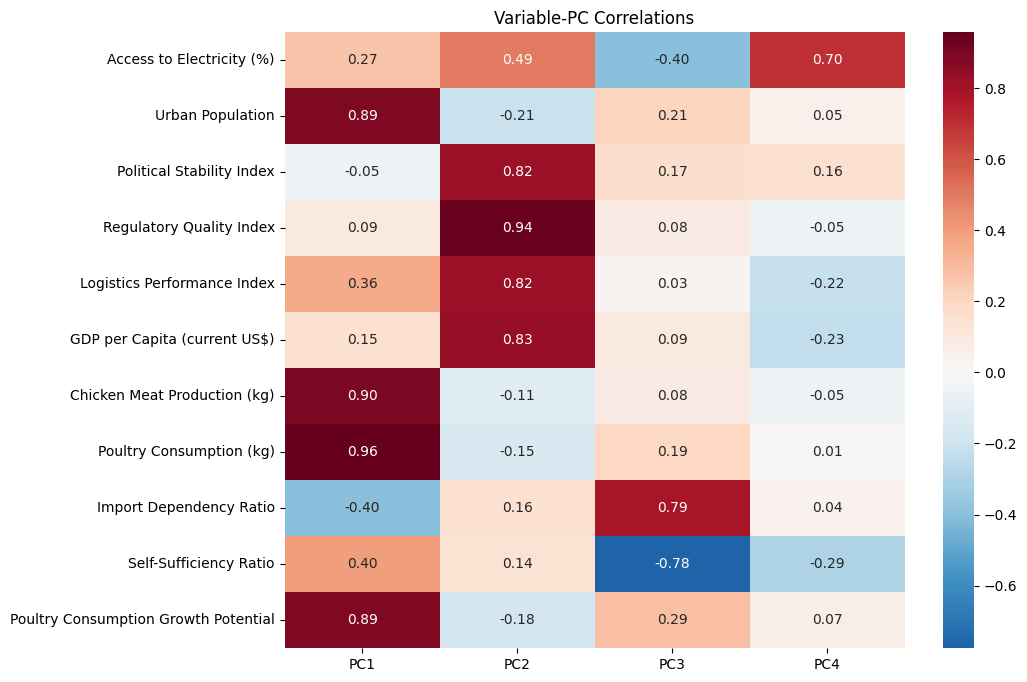

In [8]:
# Correlation between original variables and Principal Components
pca_corr = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i+1}' for i in range(len(numeric_cols))],
    index=numeric_cols
)

print("Correlation between Variables and Principal Components:")
print(pca_corr.iloc[:, :2].round(3))  # First 2 PCs

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(pca_corr.iloc[:, :4], annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Variable-PC Correlations')
plt.show()

### PCA visualization in 2D

### Scree Plot (Explained Variance)

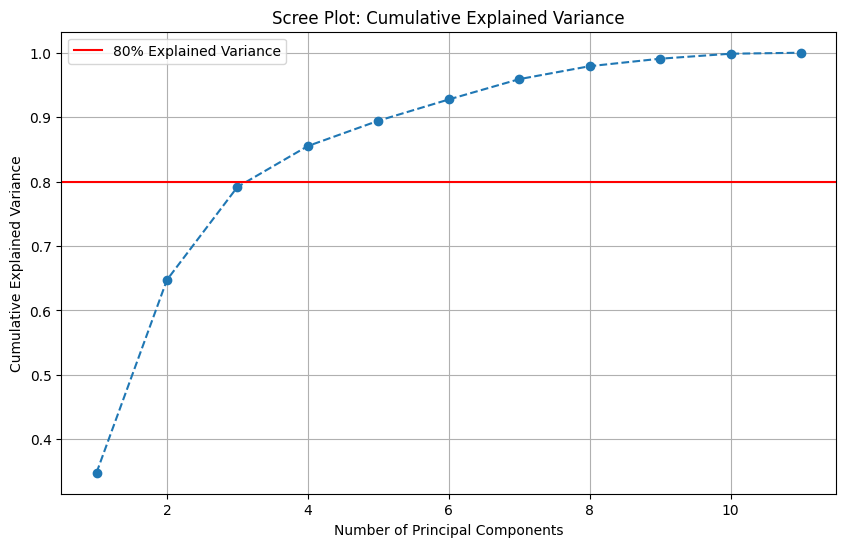

PC1: 34.82% (Cumulative: 34.82%)
PC2: 29.93% (Cumulative: 64.75%)
PC3: 14.41% (Cumulative: 79.16%)
PC4: 6.36% (Cumulative: 85.52%)
PC5: 3.92% (Cumulative: 89.44%)


In [9]:

# Scree Plot to justify number of components
pca_full = PCA()
pca_full.fit(X_scaled)
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Scree Plot: Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.8, color='r', linestyle='-', label='80% Explained Variance')
plt.legend()
plt.show()

# Display explained variance for first few components
for i, var in enumerate(explained_variance[:5]):
    print(f"PC{i+1}: {var:.2%} (Cumulative: {cumulative_variance[i]:.2%})")


In [10]:
import plotly.express as px
import plotly.graph_objects as go

# Choose number of components (2D for visualization)
pc = 2
pca_2 = PCA(n_components=pc)
X_pca_2 = pca_2.fit_transform(X_scaled)

# Prepare a DataFrame with PCs and identifiers
pc_cols = [f'PC{i+1}' for i in range(pc)]
df_pca = pd.DataFrame(X_pca_2, columns=pc_cols, index=X.index)
if ids is not None:
    df_pca = pd.concat([ids.reset_index(drop=True), df_pca.reset_index(drop=True)], axis=1)
    
# Create interactive scatter plot
fig = px.scatter(df_pca, 
                x='PC1', 
                y='PC2',
                hover_data=['Country Code'] if 'Country Code' in df_pca.columns else None,
                title='Interactive PCA: Chicken Market Analysis',
                labels={
                    'PC1': 'PC1 - Market Size Factor',
                    'PC2': 'PC2 - Economic Development Factor'
                })

# Customize hover template
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>' +
                  'Market Size (PC1): %{x:.2f}<br>' +
                  'Economic Development (PC2): %{y:.2f}' +
                  '<extra></extra>',
    hovertext=df_pca['Country Code'] if 'Country Code' in df_pca.columns else df_pca.index
)

# Add quadrant lines for market segmentation
fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_vline(x=0, line_dash="dash", line_color="gray", opacity=0.5)

# Add quadrant labels
fig.add_annotation(x=2, y=2, text="Large & Developed<br>(Premium Markets)", 
                  showarrow=False, bgcolor="lightblue", opacity=0.7)
fig.add_annotation(x=2, y=-2, text="Large & Developing<br>(Volume Markets)", 
                  showarrow=False, bgcolor="lightgreen", opacity=0.7)
fig.add_annotation(x=-2, y=2, text="Small & Developed<br>(Niche Markets)", 
                  showarrow=False, bgcolor="lightyellow", opacity=0.7)
fig.add_annotation(x=-2, y=-2, text="Small & Developing<br>(Emerging Markets)", 
                  showarrow=False, bgcolor="lightcoral", opacity=0.7)

fig.update_layout(width=800, height=600)
fig.show()

### Feature loadings

Top contributors to PC1:
Poultry Consumption (kg)                0.487178
Chicken Meat Production (kg)            0.457019
Urban Population                        0.454809
Poultry Consumption Growth Potential    0.451940
Self-Sufficiency Ratio                  0.201339
Logistics Performance Index             0.180550
Access to Electricity (%)               0.138782
GDP per Capita (current US$)            0.078379
Regulatory Quality Index                0.046933
Political Stability Index              -0.027721
Name: PC1, dtype: float64

Top contributors to PC2:
Regulatory Quality Index                0.518023
GDP per Capita (current US$)            0.457111
Logistics Performance Index             0.450992
Political Stability Index               0.447511
Access to Electricity (%)               0.269485
Import Dependency Ratio                 0.085203
Self-Sufficiency Ratio                  0.076376
Chicken Meat Production (kg)           -0.063025
Poultry Consumption (kg)               -0

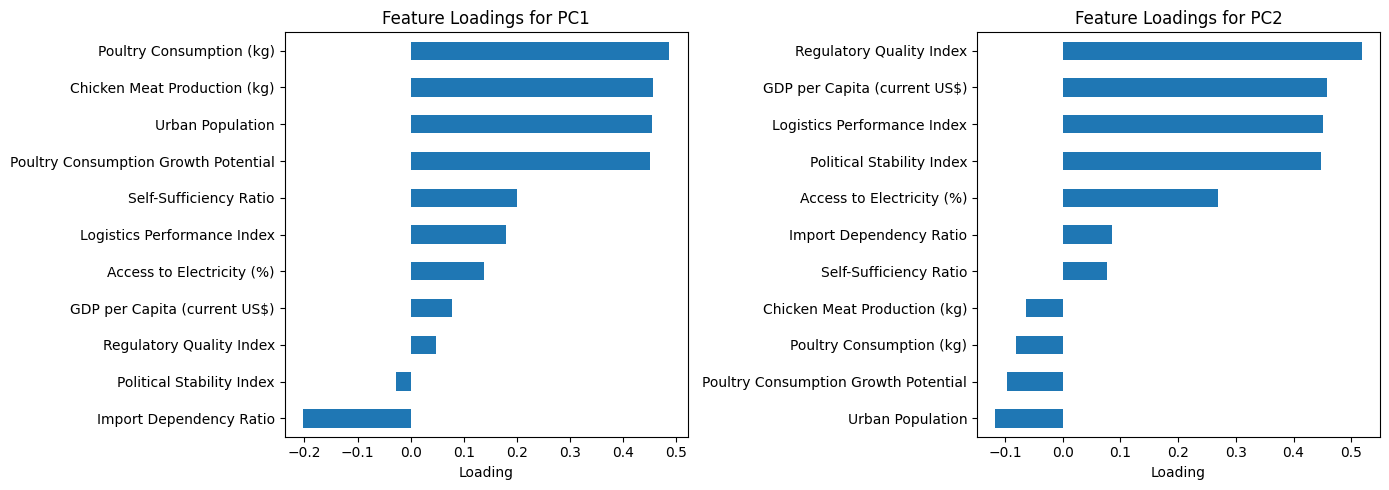

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Access to Electricity (%),0.139,0.269,-0.315,0.827,-0.328,0.112,-0.020,0.026,-0.058,0.011,-0.005
Urban Population,0.455,-0.116,0.168,0.055,0.114,0.036,-0.392,0.210,0.212,0.693,-0.103
Political Stability Index,-0.028,0.448,0.133,0.188,0.753,-0.003,0.240,0.225,-0.256,0.067,-0.007
Regulatory Quality Index,0.047,0.518,0.064,-0.061,0.062,-0.009,-0.014,-0.262,0.794,-0.137,-0.008
Logistics Performance Index,0.181,0.451,0.023,-0.258,-0.090,0.186,-0.396,-0.511,-0.482,0.058,0.016
GDP per Capita (current US$),0.078,0.457,0.074,-0.274,-0.452,-0.450,0.117,0.515,-0.116,0.071,-0.011
Chicken Meat Production (kg),0.457,-0.063,0.065,-0.061,-0.099,0.054,0.656,-0.282,-0.058,0.094,-0.494
Poultry Consumption (kg),0.487,-0.081,0.152,0.013,-0.010,-0.012,0.237,-0.061,-0.010,-0.092,0.815
Import Dependency Ratio,-0.203,0.085,0.623,0.044,-0.267,0.660,0.096,0.213,0.008,-0.009,0.006
Self-Sufficiency Ratio,0.201,0.076,-0.614,-0.345,0.066,0.554,0.050,0.363,0.069,-0.083,0.021


In [11]:
# Feature loadings (contribution of each original feature to PCs)
loadings = pd.DataFrame(
    pca.components_.T,
    index=numeric_cols,
    columns=[f'PC{i+1}' for i in range(len(numeric_cols))]
)

# Show top contributing features for PC1 and PC2
for i in range(2):
    pc_name = f'PC{i+1}'
    print(f"Top contributors to {pc_name}:")
    print(loadings[pc_name].sort_values(ascending=False).head(10))
    print()

# Visualize loadings for PC1 & PC2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, ax in enumerate(axes[:2]):
    pc_name = f'PC{i+1}'
    loading_sorted = loadings[pc_name].sort_values()
    loading_sorted.plot(kind='barh', ax=ax)
    ax.set_title(f'Feature Loadings for {pc_name}')
    ax.set_xlabel('Loading')
plt.tight_layout()
plt.show()

loadings.round(3)

### Correlation Circle

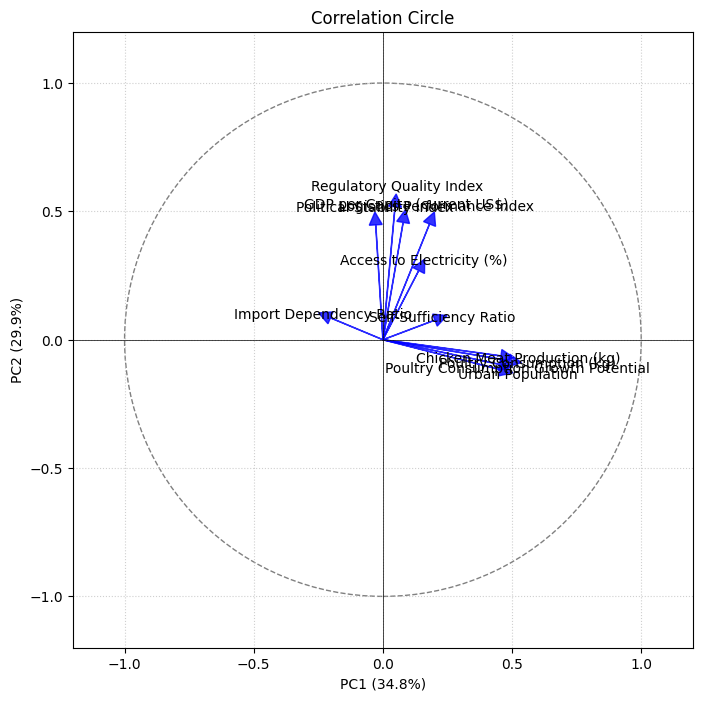

In [12]:

# Correlation Circle
def plot_correlation_circle(pca, features, x_comp=0, y_comp=1):
    # Get loadings
    loadings = pca.components_.T
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot circle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    ax.add_artist(circle)
    
    # Plot arrows
    for i, feature in enumerate(features):
        x, y = loadings[i, x_comp], loadings[i, y_comp]
        ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.05, fc='blue', ec='blue', alpha=0.8)
        ax.text(x * 1.15, y * 1.15, feature, color='black', ha='center', va='center')
        
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel(f'PC{x_comp+1} ({pca.explained_variance_ratio_[x_comp]:.1%})')
    ax.set_ylabel(f'PC{y_comp+1} ({pca.explained_variance_ratio_[y_comp]:.1%})')
    ax.set_title('Correlation Circle')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    plt.show()

plot_correlation_circle(pca_2, numeric_cols)


### Biplot + Correlation Circle
We overlay feature loadings as arrows on the PC1–PC2 scores (biplot) and show a correlation circle to interpret contributions.

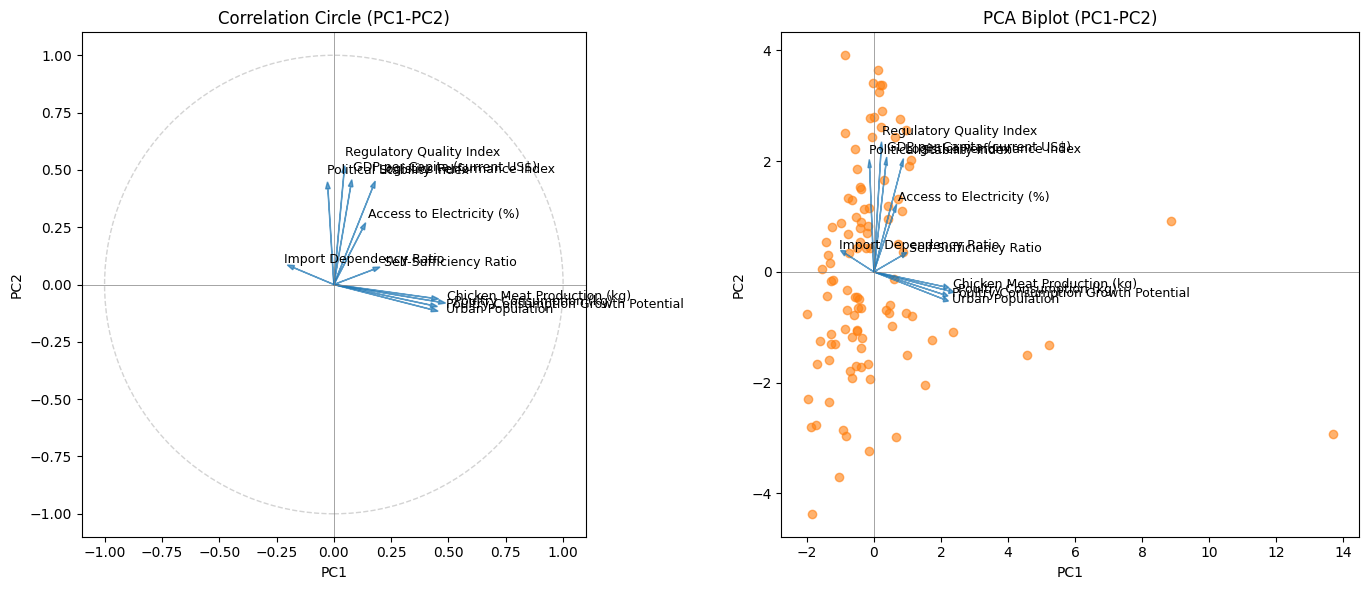

In [13]:
# Biplot: PC scores with feature loadings as arrows
# Use the PCA already fitted into `pca` (full), `numeric_cols`, `X_scaled`, and `df_pca` with PC1/PC2

# 1) Correlation circle (unit circle) and feature vectors on PC1-PC2
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# Left: correlation circle
ax0 = ax[0]
circle = plt.Circle((0,0), 1, color='lightgrey', fill=False, linestyle='--')
ax0.add_artist(circle)

# Project loadings of first two PCs
loadings_2d = pca.components_.T[:, :2]
for i, feature in enumerate(numeric_cols):
    x, y = loadings_2d[i, 0], loadings_2d[i, 1]
    ax0.arrow(0, 0, x, y, color='tab:blue', alpha=0.7, head_width=0.02, length_includes_head=True)
    ax0.text(x*1.08, y*1.08, feature, fontsize=9)

ax0.set_title('Correlation Circle (PC1-PC2)')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.axhline(0, color='grey', linewidth=0.5)
ax0.axvline(0, color='grey', linewidth=0.5)
ax0.set_aspect('equal', 'box')
ax0.set_xlim(-1.1, 1.1)
ax0.set_ylim(-1.1, 1.1)

# Right: biplot (scores + scaled loadings)
ax1 = ax[1]
ax1.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.6, color='tab:orange')

# Scale loading vectors to score space for visibility
scores_std = np.std(df_pca[['PC1','PC2']], axis=0).values
load_scale = 2.5 * scores_std  # tweak factor for readability
for i, feature in enumerate(numeric_cols):
    x, y = loadings_2d[i, 0]*load_scale[0], loadings_2d[i, 1]*load_scale[1]
    ax1.arrow(0, 0, x, y, color='tab:blue', alpha=0.7, head_width=0.02*load_scale[0], length_includes_head=True)
    ax1.text(x*1.05, y*1.05, feature, fontsize=9)

ax1.set_title('PCA Biplot (PC1-PC2)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.axhline(0, color='grey', linewidth=0.5)
ax1.axvline(0, color='grey', linewidth=0.5)
plt.tight_layout()
plt.show()

base on the attributes that related to PC1 such as import, export, consumption, production, and urbanization population, we can consider this as Market size factor. Whereas PC2 related more to the reulatory, political, gdp, logistic, and access to electricity, we can considered them as Economic development factor.

## Clustering Analysis  

### Hierarchical Clustering Dendrogram

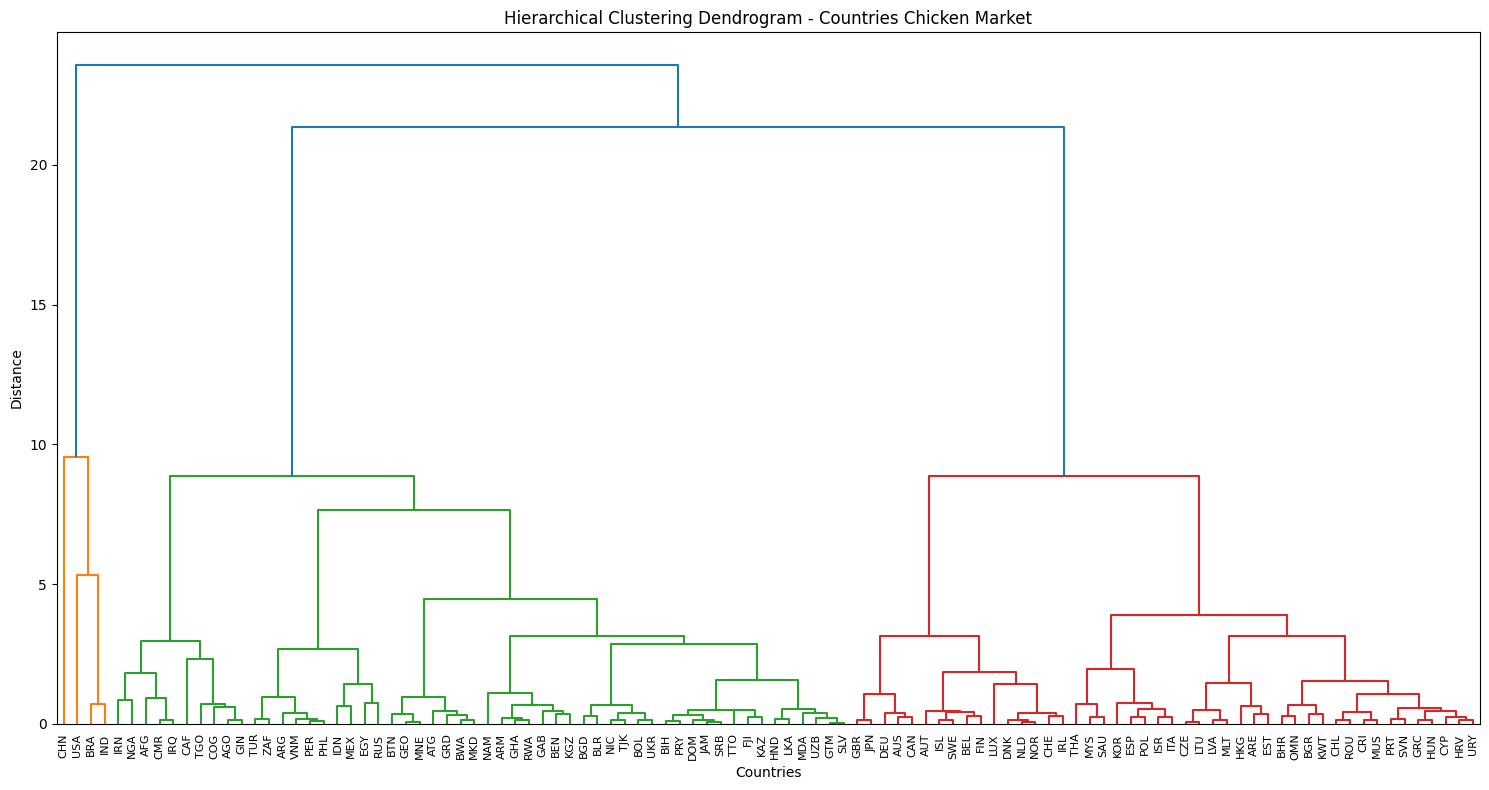

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use PCA coordinates for clustering (PC1 and PC2)
X_for_clustering = df_pca[['PC1', 'PC2']].values

# Create linkage matrix using Ward method
linkage_matrix = linkage(X_for_clustering, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendro = dendrogram(linkage_matrix, 
                   labels=df_pca['Country Code'].values if 'Country Code' in df_pca.columns else None,
                   leaf_rotation=90,
                   leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram - Countries Chicken Market')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

### Dendrogram

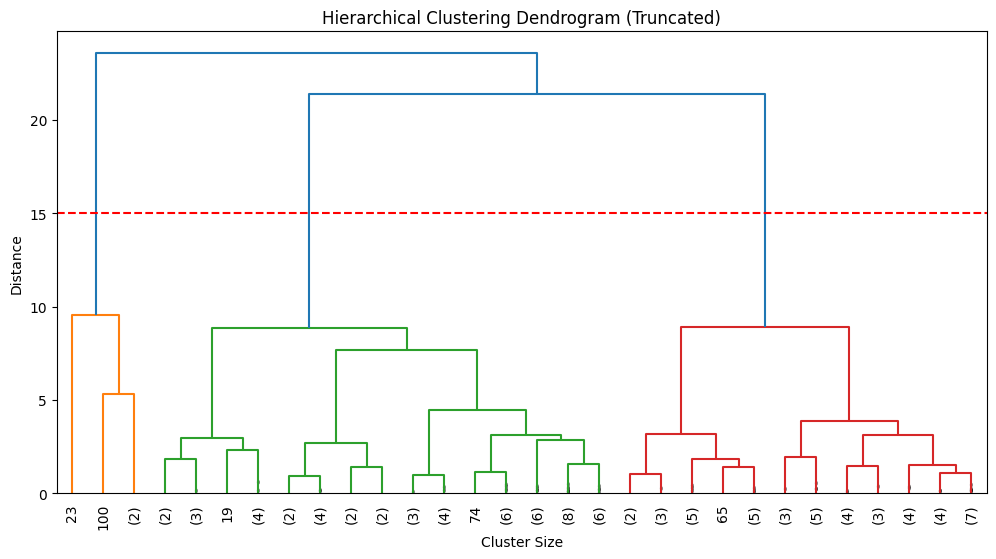

In [15]:
# Plot Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=15, color='r', linestyle='--') # Adjust threshold as needed
plt.show()


Our dendrogram shows how countries are grouped based on market characteristics. We can clearly see that there are 3 categories of countries. This implies that we can segment the markets into 3 distinct clusters for targeted strategies.

3 clusters: Silhouette = 0.460
4 clusters: Silhouette = 0.461
5 clusters: Silhouette = 0.380


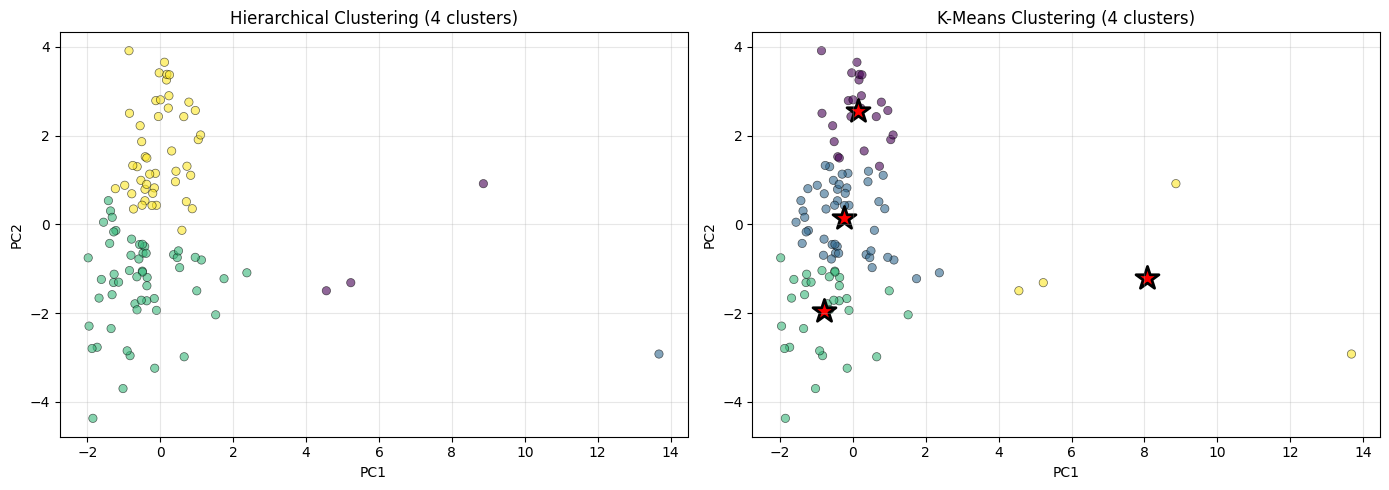

In [16]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Test different cluster numbers
for n in [3, 4, 5]:
    labels = fcluster(linkage_matrix, n, criterion='maxclust')
    sil = silhouette_score(X_for_clustering, labels)
    print(f"{n} clusters: Silhouette = {sil:.3f}")

# Use best n
best_n = 4
hierarchical_labels = fcluster(linkage_matrix, best_n, criterion='maxclust')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hierarchical
axes[0].scatter(df_pca['PC1'], df_pca['PC2'], c=hierarchical_labels, 
                cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'Hierarchical Clustering ({best_n} clusters)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(alpha=0.3)

# K-means (rerun optimal)
kmeans_final = KMeans(n_clusters=best_n, random_state=42)
kmeans_labels = kmeans_final.fit_predict(X_for_clustering)

axes[1].scatter(df_pca['PC1'], df_pca['PC2'], c=kmeans_labels,
                cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].scatter(kmeans_final.cluster_centers_[:, 0], 
                kmeans_final.cluster_centers_[:, 1],
                c='red', s=300, marker='*', edgecolors='black', linewidth=2)
axes[1].set_title(f'K-Means Clustering ({best_n} clusters)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

df_pca['Cluster'] = kmeans_labels

The Silhouette score for the dendogram showing that k=3 is the optimal number of clusters.

### K-Means Clustering  

#### Elbow Method for K-Means Clustering

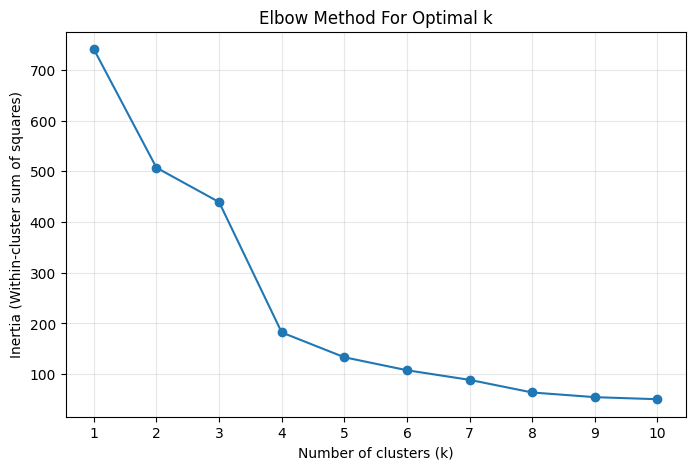

In [17]:
inertia = []
K_range = range(1, 11)
X_for_clustering = df_pca[['PC1', 'PC2']].values

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.xticks(K_range)
plt.grid(True, alpha=0.3)
plt.show()

However, based on the elbow method it seems that k=4 is a better choice than k=3. This suggests that we may want to consider 4 clusters for our K-Means analysis. 

In [18]:
for k in [3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_for_clustering)
    score = silhouette_score(X_for_clustering, labels)
    print(f"Silhouette score for k={k}: {score:.3f}")

Silhouette score for k=3: 0.305
Silhouette score for k=4: 0.364
Silhouette score for k=5: 0.408
Silhouette score for k=6: 0.412


Base on the silhouette score k=4 is much better than k=3 while k=5 and k=6 is not so different from k=4 so it is indeed that k=4 would be optimal for clustering.

In [19]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2']])

# 3. Visualize clusters
fig = px.scatter(df_pca, x='PC1', y='PC2', color='Cluster', 
                 hover_data=['Country Code'] if 'Country Code' in df_pca.columns else None,
                 title='K-means Clusters on PCA')
fig.show()

In [20]:
import plotly.express as px

# Prepare data for map visualization
map_data = df_pca.copy()

# Convert Cluster to string for better legend
map_data['Cluster_Label'] = map_data['Cluster'].astype(str)

# Create cluster names based on your PCA interpretation
cluster_names = {
    0: 'Cluster 0',
    1: 'Cluster 1', 
    2: 'Cluster 2',
    3: 'Cluster 3'
}
map_data['Cluster_Name'] = map_data['Cluster'].map(cluster_names)

# Create choropleth map
fig = px.choropleth(
    map_data,
    locations='Country Code',  # ISO country codes
    color='Cluster',
    hover_name='Country Code',
    hover_data={
        'Country Code': True,
        'PC1': ':.2f',
        'PC2': ':.2f',
        'Cluster': True,
        'Cluster_Name': True
    },
    color_continuous_scale='Viridis',
    title='Chicken Market Clusters - Global Distribution',
    labels={'Cluster': 'Market Cluster'}
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    height=600,
    width=1000
)

fig.show()

## Choosing Cluster 

In [21]:
# Merge original data with cluster assignments
cluster_analysis = df.loc[df_pca.index].copy()
cluster_analysis['Cluster'] = df_pca['Cluster']

# Profile each cluster
for cluster in sorted(cluster_analysis['Cluster'].unique()):
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster} PROFILE")
    print(f"{'='*60}")
    
    cluster_data = cluster_analysis[cluster_analysis['Cluster'] == cluster]
    print(f"Number of countries: {len(cluster_data)}")
    print(f"\nCountries: {', '.join(cluster_data['Country Code'].values[:10])}")
    if len(cluster_data) > 10:
        print(f"...and {len(cluster_data)-10} more")
    
    print(f"\n--- Key Metrics (Mean) ---")
    key_metrics = [
        'Urban Population', 'Political Stability Index', 'Regulatory Quality Index', 
        'Logistics Performance Index', 'GDP per Capita (current US$)', 'Poultry Consumption (kg)', 
        'Access to Electricity (%)', 'Chicken Meat Production (kg)', 'Import Quantity (kg)',
        'Export Quantity (kg)', 'Import Dependency Ratio', 'Self-Sufficiency Ratio',
        'Poultry Consumption Growth Potential'
    ]
    
    for metric in key_metrics:
        if metric in cluster_data.columns:
            mean_val = cluster_data[metric].mean()
            print(f"{metric}: {mean_val:,.0f}")


CLUSTER 0 PROFILE
Number of countries: 23

Countries: ARE, AUS, AUT, BEL, CAN, CHE, CZE, DEU, DNK, ESP
...and 13 more

--- Key Metrics (Mean) ---
Urban Population: 20,318,093
Political Stability Index: 1
Regulatory Quality Index: 1
Logistics Performance Index: 4
GDP per Capita (current US$): 58,173
Poultry Consumption (kg): 669,160,178
Access to Electricity (%): 100
Chicken Meat Production (kg): 561,001,241
Import Quantity (kg): 176,350,720
Export Quantity (kg): 122,551,727
Import Dependency Ratio: 45
Self-Sufficiency Ratio: 90
Poultry Consumption Growth Potential: 603,630,054

CLUSTER 1 PROFILE
Number of countries: 46

Countries: ARG, ATG, BGR, BHR, BIH, BTN, BWA, CHL, CRI, CYP
...and 36 more

--- Key Metrics (Mean) ---
Urban Population: 17,824,248
Political Stability Index: 0
Regulatory Quality Index: 0
Logistics Performance Index: 3
GDP per Capita (current US$): 16,480
Poultry Consumption (kg): 693,574,860
Access to Electricity (%): 99
Chicken Meat Production (kg): 681,318,287
Impo

In [22]:
# Weighted Scoring for Cluster Selection
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 1. Aggregate data by Cluster
numeric_features = [
    'Urban Population', 'Political Stability Index', 'Regulatory Quality Index', 
    'Logistics Performance Index', 'GDP per Capita (current US$)', 'Poultry Consumption (kg)', 
    'Access to Electricity (%)', 'Chicken Meat Production (kg)', 'Import Quantity (kg)',
    'Export Quantity (kg)', 'Import Dependency Ratio', 'Self-Sufficiency Ratio',
    'Poultry Consumption Growth Potential'
]

cluster_means = cluster_analysis.groupby('Cluster')[numeric_features].mean()

# 2. Normalize metrics (0-1 scale) for fair comparison
scaler = MinMaxScaler()
normalized_means = pd.DataFrame(scaler.fit_transform(cluster_means), 
                                columns=cluster_means.columns, 
                                index=cluster_means.index)

# 3. Define Weights (Adjust based on strategic priorities)
weights = {
    'GDP per Capita (current US$)': 0.25,    # High priority: Wealth/Purchasing Power
    'Import Dependency Ratio': 0.25,          # High priority: Need for imports
    'Poultry Consumption Growth Potential': 0.2, # Medium: Future growth
    'Logistics Performance Index': 0.1,      # Medium: Ease of doing business
    'Political Stability Index': 0.1,        # Medium priority: Stability
    'Poultry Consumption (kg)': 0.05,         # Low: Current volume
    'Access to Electricity (%)': 0.05         # Low: Basic infrastructure
}

# 4. Calculate Weighted Score
normalized_means['Score'] = 0
for feature, weight in weights.items():
    if feature in normalized_means.columns:
        normalized_means['Score'] += normalized_means[feature] * weight

# 5. Rank and Recommend
ranked_clusters = normalized_means.sort_values('Score', ascending=False)

print("\n=== Cluster Scoring & Selection ===")
print(ranked_clusters[['Score'] + list(weights.keys())].round(2))

best_cluster = ranked_clusters.index[0]
print(f"\n\nRECOMMENDATION: Select Cluster {best_cluster}")
print(f"Reasoning: Cluster {best_cluster} has the highest weighted score ({ranked_clusters.iloc[0]['Score']:.2f}), "
        f"indicating the best balance of stability, wealth, and market need.")



=== Cluster Scoring & Selection ===
         Score  GDP per Capita (current US$)  Import Dependency Ratio  \
Cluster                                                                 
0         0.75                          1.00                     1.00   
3         0.50                          0.40                     0.00   
1         0.39                          0.23                     0.72   
2         0.21                          0.00                     0.82   

         Poultry Consumption Growth Potential  Logistics Performance Index  \
Cluster                                                                      
0                                        0.01                         1.00   
3                                        1.00                         0.75   
1                                        0.03                         0.42   
2                                        0.00                         0.00   

         Political Stability Index  Poultry Consumption

## Target Country Selection
Based on the cluster analysis, **Cluster 0** has been identified as the optimal cluster due to its high stability, wealth, and market potential. We will now select the best country from this cluster.

In [23]:
# Filter for Cluster 0
target_cluster = 0
target_countries = cluster_analysis[cluster_analysis['Cluster'] == target_cluster].copy()

print(f"Number of countries in Cluster {target_cluster}: {len(target_countries)}")
print(target_countries['Country Name'].values)

Number of countries in Cluster 0: 23
['United Arab Emirates' 'Australia' 'Austria' 'Belgium' 'Canada'
 'Switzerland' 'Czechia' 'Germany' 'Denmark' 'Spain' 'Estonia' 'Finland'
 'United Kingdom' 'Hong Kong SAR, China' 'Ireland' 'Iceland' 'Japan'
 'Korea, Rep.' 'Lithuania' 'Luxembourg' 'Netherlands' 'Norway' 'Sweden']


In [24]:
from sklearn.preprocessing import MinMaxScaler

# Define ranking metrics and weights for country selection
# We want high import quantity, high growth potential, stability, and wealth.

ranking_weights = {
    'GDP per Capita (current US$)': 0.25,    # High priority: Wealth/Purchasing Power
    'Import Dependency Ratio': 0.25,          # High priority: Need for imports
    'Poultry Consumption Growth Potential': 0.2, # Medium: Future growth
    'Logistics Performance Index': 0.1,      # Medium: Ease of doing business
    'Political Stability Index': 0.1,        # Medium priority: Stability
    'Poultry Consumption (kg)': 0.05,         # Low: Current volume
    'Access to Electricity (%)': 0.05         # Low: Basic infrastructure
}

# Normalize metrics for the target countries
scaler = MinMaxScaler()
ranking_metrics = list(ranking_weights.keys())
normalized_target = pd.DataFrame(scaler.fit_transform(target_countries[ranking_metrics]), 
                                 columns=ranking_metrics, 
                                 index=target_countries.index)

# Calculate Country Score
target_countries['Country_Score'] = 0
for metric, weight in ranking_weights.items():
    target_countries['Country_Score'] += normalized_target[metric] * weight

# Sort by score
top_candidates = target_countries.sort_values('Country_Score', ascending=False)

# Display top 10
cols_to_show = ['Country Name', 'Country_Score'] + ranking_metrics
top_candidates[cols_to_show].head(10)

,Country Name,Country_Score,GDP per Capita (current US$),Import Dependency Ratio,Poultry Consumption Growth Potential,Logistics Performance Index,Political Stability Index,Poultry Consumption (kg),Access to Electricity (%)
65,Luxembourg,0.593178,123719.658916,108.232066,2.882945e+07,3.6,1.064390,1.284421e+07,100.0
2,United Arab Emirates,0.551318,49899.065298,108.269543,2.754101e+09,4.0,0.744183,5.131117e+08,100.0
77,Netherlands,0.543347,59123.318556,157.469445,3.091290e+08,4.1,0.726800,2.392819e+08,100.0
21,Switzerland,0.457859,94394.510680,23.450899,1.507934e+08,4.1,1.159745,1.571457e+08,100.0
51,Ireland,0.456607,105234.511568,52.040965,3.841170e+08,3.6,0.884667,1.597720e+08,100.0
20,Canada,0.445427,56256.800726,10.199922,3.056717e+09,4.0,0.780682,1.587841e+09,100.0
78,Norway,0.382768,109269.520580,0.908379,1.527672e+08,3.7,0.861239,1.168993e+08,100.0
45,"Hong Kong SAR, China",0.382438,48825.844187,107.046094,-3.019925e+08,4.0,0.574927,3.326222e+08,100.0
38,United Kingdom,0.381008,46062.991408,21.577353,2.883072e+09,3.7,0.533176,2.376344e+09,100.0
8,Belgium,0.379735,50822.251854,89.308823,1.605505e+08,4.0,0.581982,1.900335e+08,100.0


In [25]:
# Visualize Top 5 Candidates
top5 = top_candidates.head(5)

fig = px.bar(top5, x='Country Name', y='Country_Score',
             title='Top 5 Target Countries in Cluster 0',
             color='Country_Score',
             color_continuous_scale='Viridis')
fig.show()

best_country = top5.iloc[0]['Country Name']
print(f"\nThe recommended target country is: {best_country}")


The recommended target country is: Luxembourg
